# Web Scraping with lazy load

Page to be scraped: El Espectador

# Parte 1

In [10]:
# Importing required libraries parte 1

import time

from bs4 import BeautifulSoup

# Solved deprecation warning: https://exerror.com/deprecationwarning-executable_path-has-been-deprecated-please-pass-in-a-service-object/
from selenium import webdriver
from selenium.webdriver.firefox.service import Service

from pymongo import MongoClient


# Importing required libraries parte 2

import os

import re

import string

import pandas as pd

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

from wordcloud import WordCloud

import spacy
from spacy import displacy

import matplotlib.pyplot as plt
%matplotlib inline

jar = "./pos-tagger/stanford-postagger/stanford-postagger-4.2.0.jar"
model = "./pos-tagger/stanford-postagger/models/spanish-ud.tagger"
os.environ["JAVAHOME"] = "/usr/bin/java"

nlp = spacy.load('es_core_news_md')

In [11]:
# Creating a connection to MongoDB
client = MongoClient('localhost', 27017)
db = client['news']
collection = db['elespectador']

In [12]:
# Base URL of the site to be analyzed
SITE_URL = 'https://www.elespectador.com'

In [13]:
# Download the driver for you S.O. here: https://github.com/mozilla/geckodriver/releases

# Firefox1 web driver path
s1 = Service('./geckodriverC')

# Firefox web driver path
s2 = Service('./geckodriverF')

In [14]:
def make_request(browser, relative_path):
    # Making the request and rendering the browser
    browser.get(SITE_URL + relative_path)
    
    # Simulating vertical scrolling for handling lazy load
    check_height = browser.execute_script('return document.body.scrollHeight;')
    while True:
        browser.execute_script('window.scrollTo(0, document.body.scrollHeight);')
        time.sleep(6)
        height = browser.execute_script('return document.body.scrollHeight;')
        if height == check_height: 
            break 
        check_height = height
    
    # Getting HTML content and passing it to BeautifulSoup for scraping analysis
    return BeautifulSoup(browser.page_source, 'html.parser')

In [15]:
# List with the categories of topics
path_categories = ['politica', 'judicial', 'colombia', 'economia', 'bogota']

# Number of pages to consult in each category
number_pages = 2

In [ ]:
# Building a list with title and relative path of the news founded
news = []

# Iterate over the list of categories
for cat in path_categories:
    
    # Check number of pages
    for num in range(number_pages):
                    
        # Creating a firefox window for the archive for each category
        browser_archive = webdriver.Firefox(service=s1)
                      
        # Getting HTML content for a particular news listing page
        soup = make_request(browser_archive, '/archivo/' + cat + '/' + str(num+1) + '/')
        
        # Finding the section where news are contained
        layout = soup.find(class_ = 'Layout-flexAds')
        
        # Getting blocks from layout
        blocks = layout.find_all(class_ = 'Container Block', recursive = True)
        #print(len(blocks))
        
        # Finding and concatenating news cards
        cards = blocks[0].find_all(class_ = 'Card_rowCardLeft') + blocks[1].find_all(class_ = 'Card_rowCardLeft')
        #print(blocks[0].find_all(class_ = 'Card_rowCardLeft'))
        #print(len(cards))
        #print(cards)
        
        # Close the firefox window
        browser_archive.close()
        
        # Iterate over each card obtained in the blocks
        for card in cards:
            
            # Avoiding premium articles
            if card.find(class_ = 'Card-ExclusiveContainer') == None:
                
                # Add the items to the list
                news.append({
                    'title': card.find('h2', class_ = 'Card-Title').find('a').get_text(),
                    'relative_path': card.find('h2', class_ = 'Card-Title').find('a')['href'],
                    'category': cat
                })

In [9]:
type(news)

list

In [10]:
news

[{'title': '‘Hay un plan para infiltrar mi campaña con dineros del narcotráfico’: Petro',
  'relative_path': '/politica/elecciones-colombia-2022/hay-un-plan-para-infiltrar-mi-campana-con-dineros-del-narcotrafico-denuncia-gustavo-petro/',
  'category': 'politica'},
 {'title': '¿Duque rompió relaciones con Rusia por invasión a Ucrania?',
  'relative_path': '/politica/duque-rompio-relaciones-con-rusia-por-invasion-a-ucrania/',
  'category': 'politica'},
 {'title': 'Francia Márquez no conoce la paz ni la tranquilidad hace veinte años',
  'relative_path': '/politica/francia-marquez-no-conoce-la-paz-ni-la-tranquilidad-hace-veinte-anos/',
  'category': 'politica'},
 {'title': 'Reforma rural, apertura de macro casos: las peticiones de víctimas en el Congreso',
  'relative_path': '/politica/reforma-rural-apertura-de-macro-casos-en-la-jep-las-peticiones-de-victimas-en-el-congreso/',
  'category': 'politica'},
 {'title': 'Las indirectas de Iván Duque a las propuestas de Petro',
  'relative_path':

In [11]:
 for n in news:
                            
        # Creating a firefox window for article
        browser_article = webdriver.Firefox(service=s2)

        # Getting HTML content for each news page
        soup = make_request(browser_article, n['relative_path'])

        # Extracting news metadata
        n['datetime'] = soup.find(class_ = 'ArticleHeader-Date').get_text()
        n['author'] = soup.find(class_ = 'ACredit-Author').get_text()
        n['summary'] = soup.find(class_ = 'ArticleHeader-Hook').find('div').get_text()

        # Extracting and concatenating news full text
        paragraphs = soup.find_all(class_ = 'font--secondary')
        n['full_text'] = ' '.join([p.get_text() for p in paragraphs])                    
        browser_article.close()

In [17]:
news

[{'title': '‘Hay un plan para infiltrar mi campaña con dineros del narcotráfico’: Petro',
  'relative_path': '/politica/elecciones-colombia-2022/hay-un-plan-para-infiltrar-mi-campana-con-dineros-del-narcotrafico-denuncia-gustavo-petro/',
  'category': 'politica',
  'datetime': '10 Apr 2022  - 10:07 a.\xa0m.',
  'author': 'Redacción Política',
  'summary': 'El candidato presidencial Gustavo Petro denunció que, desde las cárceles, se estaría gestando un plan para ingresar dineros ilícitos a su campaña. El Inpec lo invitó a que denuncie formalmente lo que sabe.',
  'full_text': 'A contadas semanas de las elecciones presidenciales, el candidato del Pacto Histórico, Gustavo Petro denunció en su cuenta de Twitter un supuesto plan para infiltrar su campaña con dineros del narcotráfico. La estrategia, dijo el senador y exalcalde de Bogotá, se estaría gestando al interior de las cárceles. Desde el Inpec le contestaron que denuncie ante las autoridades con la información que tiene. El 9 de abril

In [20]:
len(news)

108

In [33]:
# Storing extracted information for further analysis
collection.insert_many(news)

# Parte 2

In [51]:
# Method to select category and clean corpus
# input "None" to select all categories
def clean_selectCategory(category):
    
    # Check for category
    if category == None:
        
        # Extract data from db to a list
        list_full_text = []
        for news in list(collection.find({}, {"title": 1, "summary": 1, "full_text": 1, "_id": 0})):
            list_full_text.append(news["title"])
            list_full_text.append(news["summary"])
            list_full_text.append(news["full_text"])
            
    else:
        
        # Extract data from db to a list
        list_full_text = []
        for news in list(collection.find({"category":category}, {"title": 1, "summary": 1, "full_text": 1, "_id": 0})):
            list_full_text.append(news["title"])
            list_full_text.append(news["summary"])
            list_full_text.append(news["full_text"])        
        
        
    # Join items of list in an unique item
    list_corpus = " ".join(list_full_text)

    # Transform text to lower case
    list_corpus_lower = list_corpus.lower()

    # Remove punctuation
    list_corpus_punct = list_corpus_lower.translate(str.maketrans('', '', '¿!’"#‘$“%–“&\'\()*+,-./:;<”=>?@[\\]^_`{|}~'))

    # Remove multiple spaces
    list_corpus_clean = re.sub(' +', ' ', list_corpus_punct)

    # Word tokenization
    #nltk.download('punkt')
    tokenize_corpus = word_tokenize(list_corpus_clean, language = 'spanish')

    # Obtaining Stop words in spanish
    #nltk.download('stopwords')
    stop_words = set(stopwords.words("spanish"))

    # Removing stop words
    filtered_corpus = []

    for w in tokenize_corpus:
        if w.lower() not in stop_words:
            filtered_corpus.append(w)
            
    return filtered_corpus  

In [55]:
# FULL CORPUS ANALISYS

# Assign tokenized corpus to a list
full = clean_selectCategory(None)

# Words distribution
full_frec_dist_corpus = FreqDist(full)

# Printing the most common words
full_frec_dist_corpus.most_common(10)

[('bogotá', 141),
 ('semana', 122),
 ('colombia', 120),
 ('país', 119),
 ('puede', 119),
 ('nacional', 115),
 ('lea', 111),
 ('parte', 110),
 ('personas', 104),
 ('víctimas', 98)]

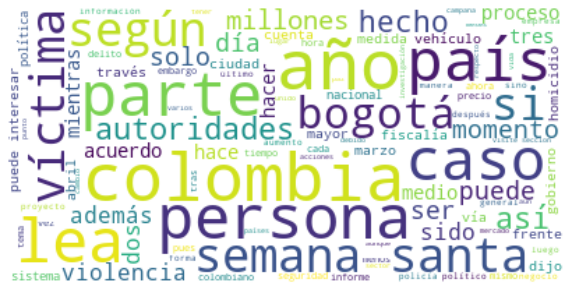

In [56]:
# Creating the wordcloud for all collection news
# Word size is directly related to frecuency
full_wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(" ".join(full))

plt.figure(figsize = (10, 10))
plt.imshow(full_wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [57]:
# "POLITICA" CORPUS ANALISYS

# Assign tokenized corpus to a list
list_politica = clean_selectCategory('politica')

# Words distribution
politica_frec_dist_corpus = FreqDist(list_politica)

# Printing the most common words
politica_frec_dist_corpus.most_common(10)

[('país', 40),
 ('petro', 38),
 ('colombia', 35),
 ('duque', 34),
 ('paz', 29),
 ('víctimas', 28),
 ('campaña', 27),
 ('presidente', 27),
 ('candidato', 26),
 ('autoridades', 25)]

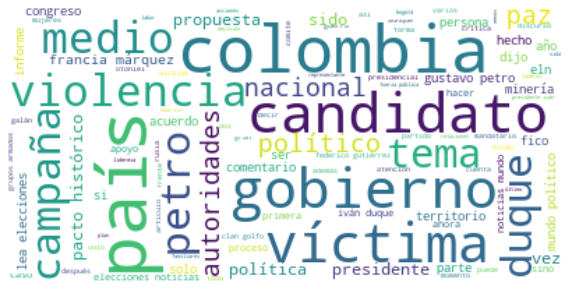

In [59]:
# Creating the wordcloud for "politica" collection news
# Word size is directly related to frecuency
politica_wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(" ".join(list_politica))

plt.figure(figsize = (10, 10))
plt.imshow(politica_wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [60]:
# "JUDICIAL" CORPUS ANALISYS

# Assign tokenized corpus to a list
list_judicial = clean_selectCategory('judicial')

# Words distribution
judicial_frec_dist_corpus = FreqDist(list_judicial)

# Printing the most common words
judicial_frec_dist_corpus.most_common(10)

[('fiscalía', 39),
 ('caso', 33),
 ('parte', 30),
 ('justicia', 29),
 ('según', 27),
 ('nacional', 26),
 ('autoridades', 26),
 ('personas', 25),
 ('seguridad', 25),
 ('colombia', 25)]

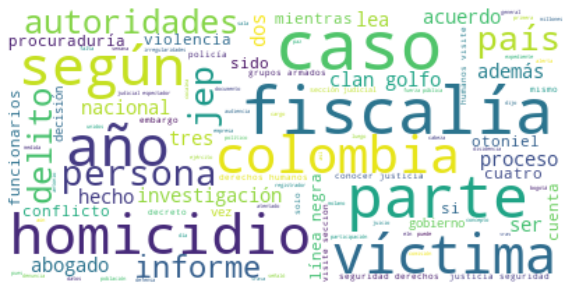

In [61]:
# Creating the wordcloud for "judicial" collection news
# Word size is directly related to frecuency
judicial_wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(" ".join(list_judicial))

plt.figure(figsize = (10, 10))
plt.imshow(judicial_wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [62]:
# "COLOMBIA" CORPUS ANALISYS

# Assign tokenized corpus to a list
list_colombia = clean_selectCategory('colombia')

# Words distribution
colombia_frec_dist_corpus = FreqDist(list_colombia)

# Printing the most common words
colombia_frec_dist_corpus.most_common(10)

[('semana', 33),
 ('puede', 33),
 ('personas', 30),
 ('medellín', 30),
 ('santa', 27),
 ('año', 23),
 ('antioquia', 23),
 ('según', 21),
 ('seguridad', 20),
 ('nacional', 20)]

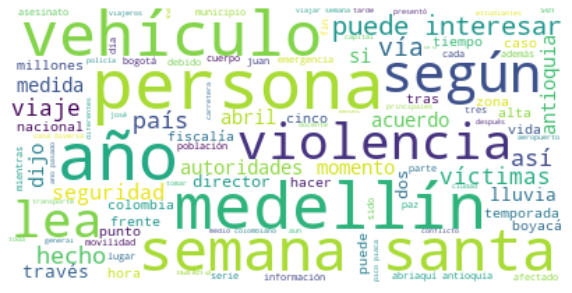

In [63]:
# Creating the wordcloud for "colombia" collection news
# Word size is directly related to frecuency
colombia_wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(" ".join(list_colombia))

plt.figure(figsize = (10, 10))
plt.imshow(colombia_wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [64]:
# "ECONOMIA" CORPUS ANALISYS

# Assign tokenized corpus to a list
list_economia = clean_selectCategory('economia')

# Words distribution
economia_frec_dist_corpus = FreqDist(list_economia)

# Printing the most common words
economia_frec_dist_corpus.most_common(10)

[('millones', 50),
 ('semana', 43),
 ('colombia', 42),
 ('precios', 39),
 ('año', 38),
 ('vehículos', 38),
 ('lea', 34),
 ('nacional', 33),
 ('si', 33),
 ('parte', 33)]

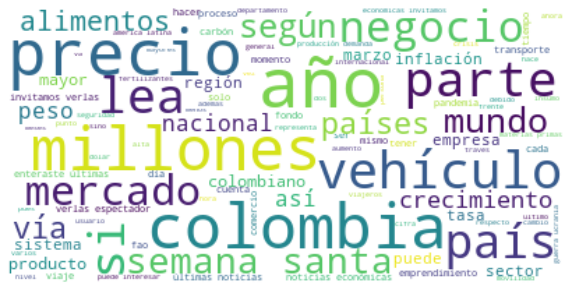

In [65]:
# Creating the wordcloud for "economia" collection news
# Word size is directly related to frecuency
economia_wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(" ".join(list_economia))

plt.figure(figsize = (10, 10))
plt.imshow(economia_wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [66]:
# "BOGOTA" CORPUS ANALISYS

# Assign tokenized corpus to a list
list_bogota = clean_selectCategory('bogota')

# Words distribution
bogota_frec_dist_corpus = FreqDist(list_bogota)

# Printing the most common words
bogota_frec_dist_corpus.most_common(10)

[('bogotá', 101),
 ('hrs', 46),
 ('capital', 39),
 ('cl', 36),
 ('cr', 34),
 ('santa', 32),
 ('semana', 31),
 ('ciudad', 30),
 ('años', 29),
 ('víctimas', 26)]

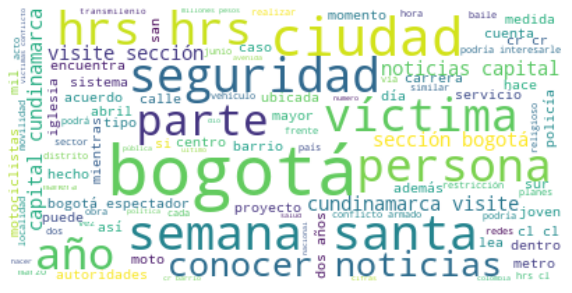

In [67]:
# Creating the wordcloud for "bogota" collection news
# Word size is directly related to frecuency
bogota_wordcloud = WordCloud(max_font_size = 50, max_words = 100, background_color = "white").generate(" ".join(list_bogota))

plt.figure(figsize = (10, 10))
plt.imshow(bogota_wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [5]:
# Named Entity Recognition (NER) for "politica" corpus

# Extract data from db to a list
list_full_ner = []
for news in list(collection.find({"category":'politica'}, {"title": 1, "summary": 1, "full_text": 1, "_id": 0})):
    list_full_ner.append(news["title"])
    list_full_ner.append(news["summary"])
    list_full_ner.append(news["full_text"])

str_ner = " ".join(list_full_ner)


# Named Entity Recognition (NER)
document_ner = nlp(str_ner)
displacy.render(document_ner, style = "ent")